In [5]:
import pandas as pd
%matplotlib inline
import numpy as np

X - таблица признаков, которая нам поможет предсказать исход игры: radaint_Heroes, dire_Heroes - это 5 героев взятых из пула всех игроков, radiant_items, dire_items - это предметы взятые игроками за определенного героя

In [6]:
X = pd.read_csv('./mapped_match_hero_item.csv')
X.head()

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_vanguard,dire_veil_of_discord,dire_vitality_booster,dire_vladmir,dire_void_stone,dire_ward_dispenser,dire_ward_observer,dire_ward_sentry,dire_wraith_band,dire_yasha
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [7]:
X.shape

(50000, 612)

y - это целевая переменная, используемая при предсказании исхода матча

In [8]:
matches = pd.read_csv('./match.csv')
y = matches['radiant_win'].apply(lambda win: 1 if win else 0)
classes = ['Dire Win', 'Radiant Win']

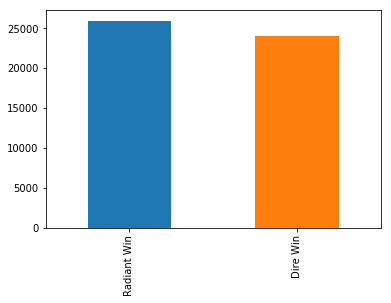

In [9]:
_ = pd.Series(y).apply(lambda i: classes[i]).value_counts().plot('bar')

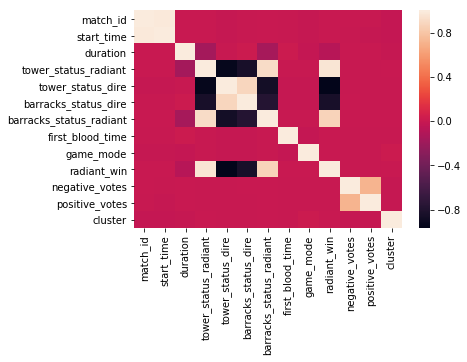

In [10]:
import seaborn as sns
corr = matches.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Здесь строится дерево решений, помогающая определить, какой предмет надо взять сторонам(Radiant, Dire), чтобы гарантированно выиграть матч

In [11]:
import io
from scipy import misc
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
import pydotplus

In [22]:
def show_tree(decisionTree, file_path):
    dotfile = io.StringIO()
    export_graphviz(decisionTree, 
                    max_depth=4,
                    label=None,
                    impurity=False,
                    filled=True,
                    rounded=True,
                    proportion=False,
                    rotate=True,
                    out_file=dotfile, 
                    class_names=classes, 
                    feature_names=X.columns)
    pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
    i = misc.imread(file_path)
    plt.figure(figsize=(100,100))
    plt.imshow(i, interpolation='nearest')

In [23]:
def build_decision_tree(X, y, depth=None):
    dt = DecisionTreeClassifier(random_state=42, max_depth=depth)
    print('CV score:', cross_val_score(estimator=dt, X=X, y=y).mean())
    dt.fit(X, y)
    show_tree(dt, 'tree.png')
    return dt

/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CV score: 0.8334800050668854


/home/dario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


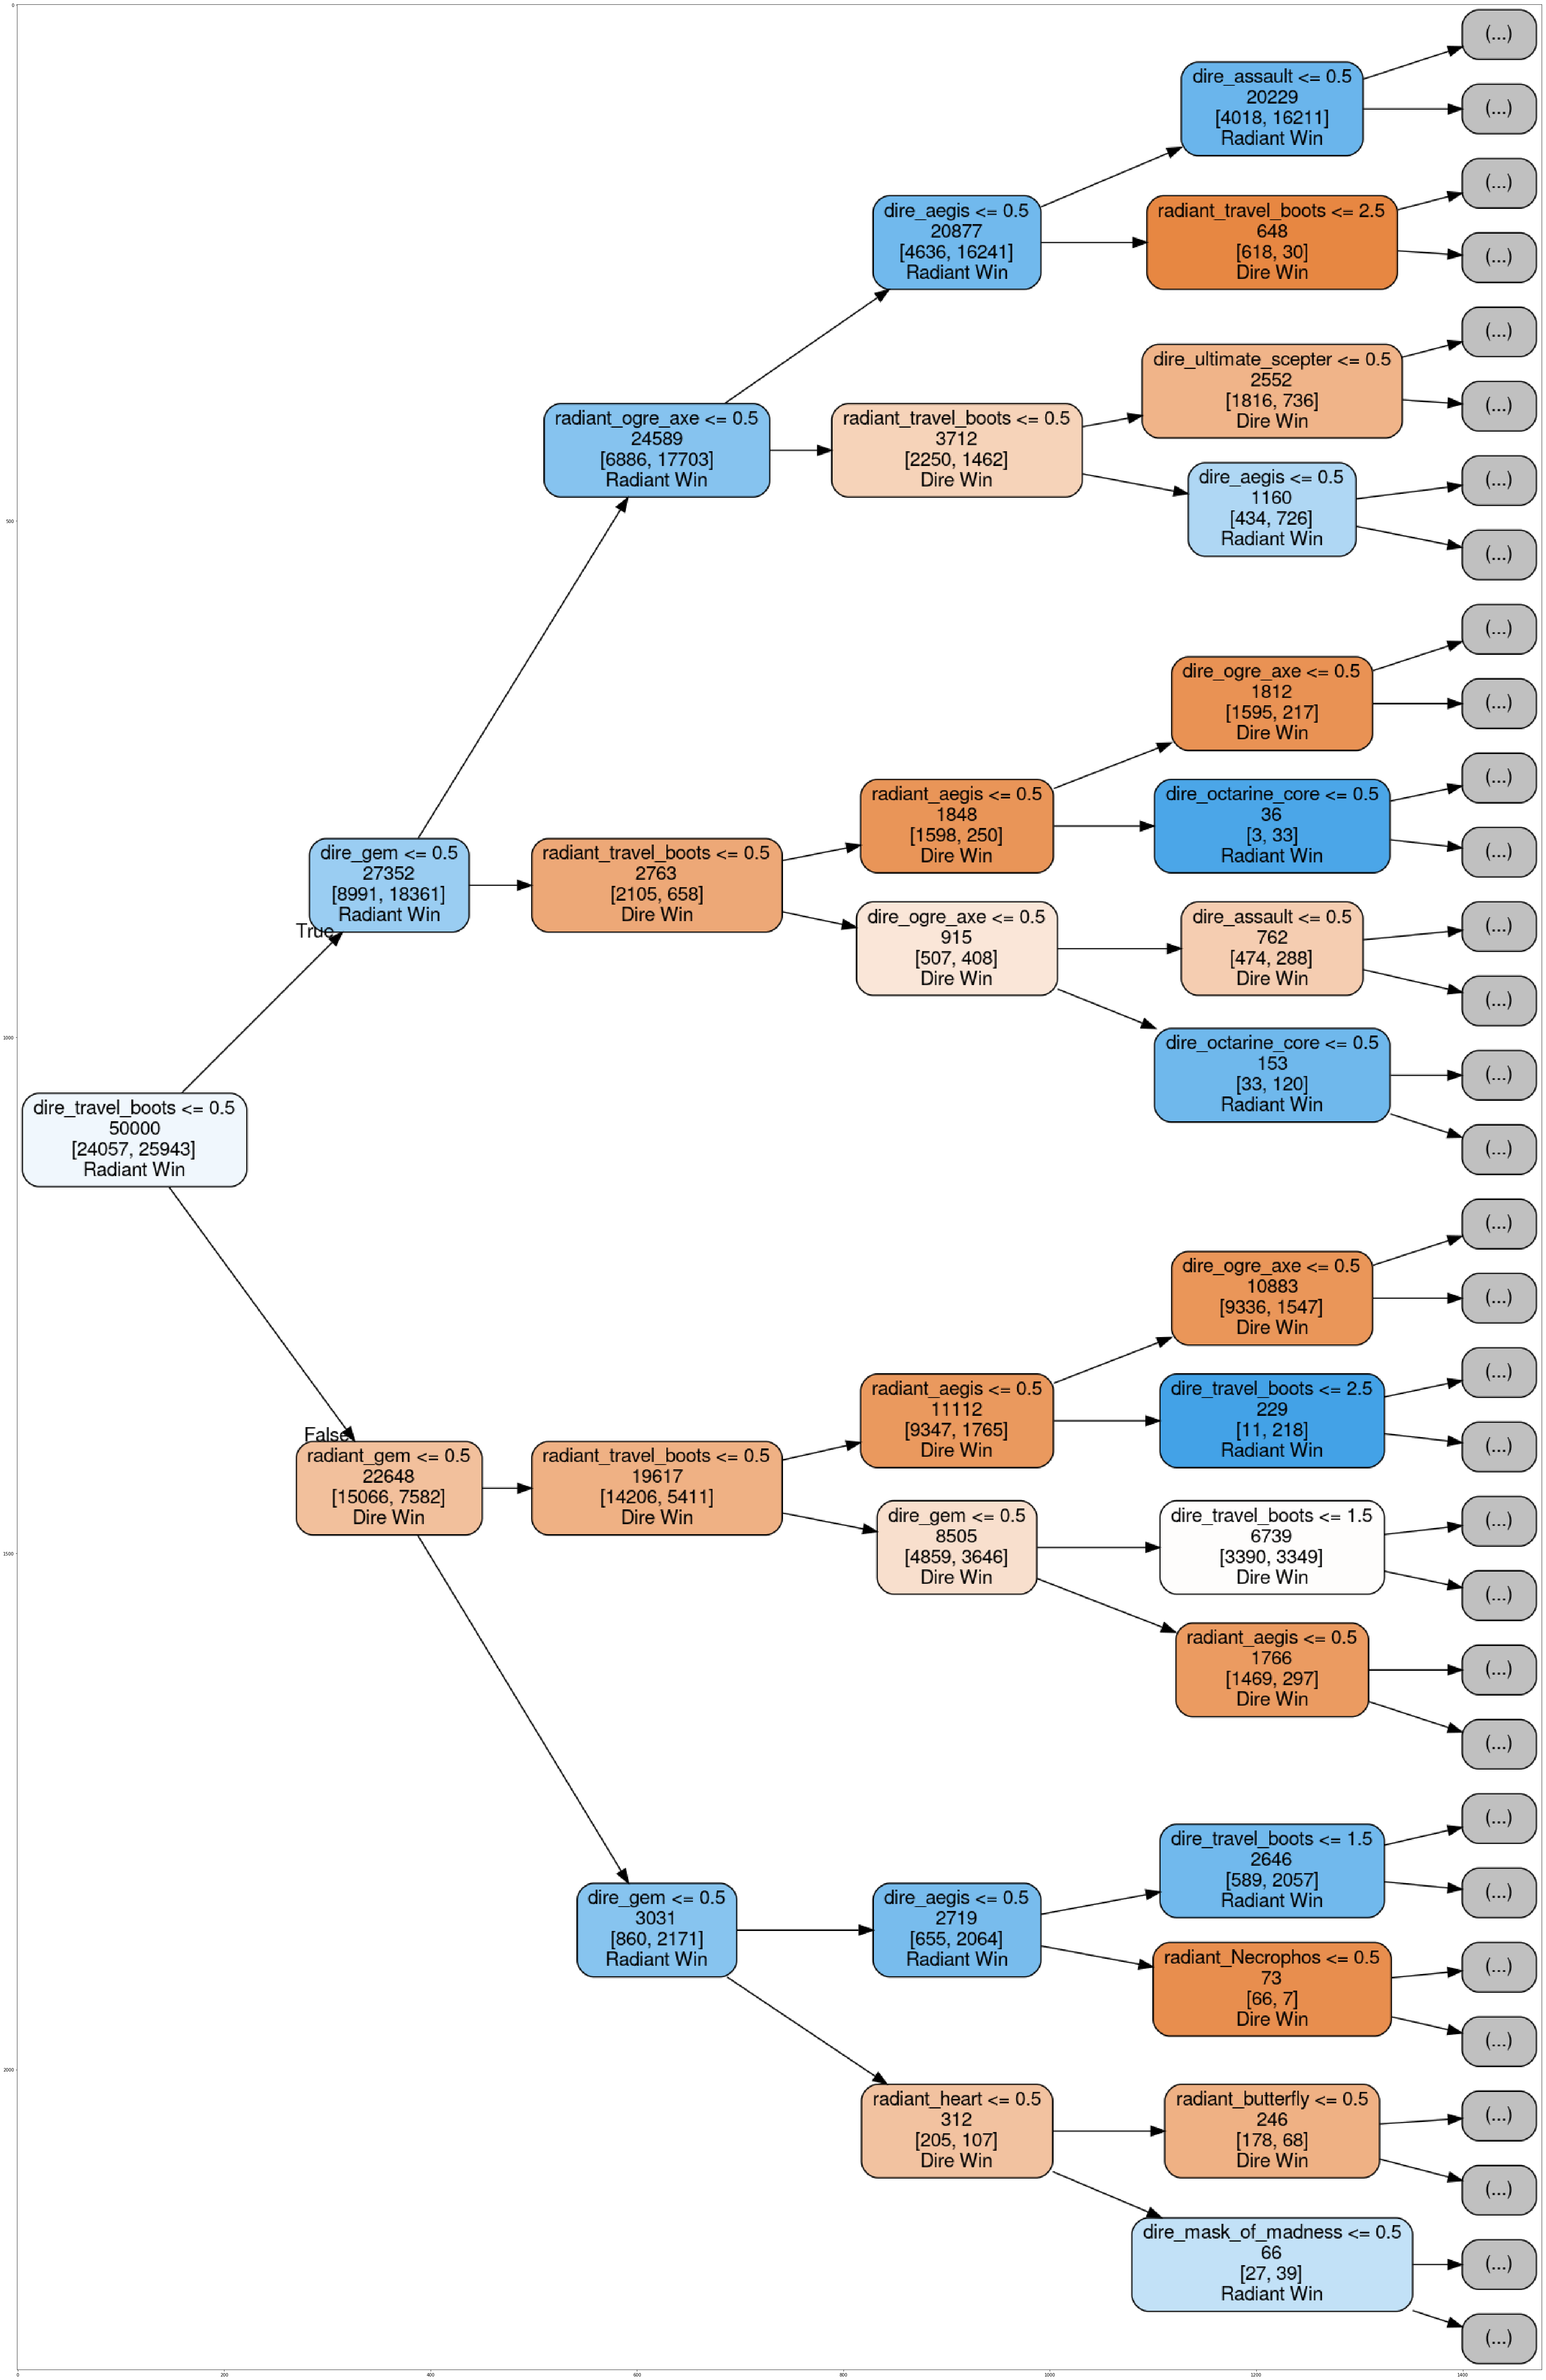

In [24]:
dt = build_decision_tree(X=X, y=y, depth=10)

Здесь выводится список 20 предметов, которые помогут победить в матче с обеих сторон, которые использовались в дереве принятия решений.

In [25]:
def get_stats_from_tree(dt):
    feature_importances = dict(zip(X.columns, dt.feature_importances_))
    feature_importances = pd.Series(feature_importances).sort_values(ascending=False)
    return feature_importances.iloc[feature_importances.nonzero()]

get_stats_from_tree(dt).head(20)

dire_travel_boots          0.203223
dire_gem                   0.104874
radiant_travel_boots       0.103673
radiant_gem                0.077311
radiant_ogre_axe           0.062642
dire_aegis                 0.059328
dire_assault               0.047569
radiant_Unknown.1          0.040661
radiant_aegis              0.033091
dire_butterfly             0.028862
dire_ogre_axe              0.025828
radiant_assault            0.020026
dire_Unknown.1             0.018916
dire_guardian_greaves      0.018145
dire_ultimate_scepter      0.013536
radiant_butterfly          0.012071
dire_abyssal_blade         0.010682
radiant_monkey_king_bar    0.010277
radiant_abyssal_blade      0.007701
dire_moon_shard            0.007699
dtype: float64

Подготовка тренировочных и тестовых данных, для больших размеров данных (> 10000) используется соотношение тренировочных/тестовых данных = 70/30 (%)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

N_train, _ = X_train.shape
N_test, _ = X_test.shape
print(N_train, N_test)

35000 15000


Используем метод k ближайших соседей 

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [32]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_predict)
err_test = np.mean(y_test != y_test_predict)
print(err_train, err_test)

0.06357142857142857 0.11486666666666667


In [16]:
from sklearn.model_selection import GridSearchCV
n_neighbors_array = [1, 3, 5, 7, 10, 15]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors' : n_neighbors_array})
grid.fit(X_train, y_train)

best_cv_error = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_error, best_n_neighbors)

/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.0889428571428571 15


In [17]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))
print(err_train, err_test)

0.07008571428571428 0.089
